# Doing Post Hoc Test with Python

## What is Pos Hoc Test?  
Let's say, you are doing a simple analysis on Titanic dataset. You wanted to know if there's a different of `fare` between pclasses. You can do the analysis with a simple barchart below, which showed that the pclass 1 had higher fare on average compared to pclass 2 and 3. But this way of analysis is very subjective, therefore to confirm your conclusion, you are doing a hypothesis testing.

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway, kruskal, ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from scikit_posthocs._posthocs import posthoc_tukey_hsd, posthoc_ttest
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [3]:
titanic=sns.load_dataset('titanic')
# titanic

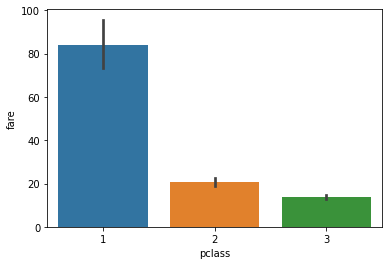

In [11]:
sns.barplot(data=titanic, x='pclass',y='fare')

For the sake of simplicity, let's assume that `fare` variable has a normal distribution and equal variance between groups. To test if there is a difference in `fare` between pclass, we can use `f_oneway` from scipy library.

In [5]:
stats,pval=f_oneway(*[titanic['pclass']==i for i in titanic['pclass'].unique()])
if pval<=0.05:
    print(f'pval={pval}, reject Ho')
else:
    print(f'pval={pval}, accept Ho')

pval=9.431642534056226e-67, reject Ho


After doing the test, we reject Ho, which mean **at least a pair of group** has difference, but we don't know which pair. To determine which pairs have differences, we can do further test. A statistical test done **after we reject Ho** in ANOVA test (such as F test or Kruskal Wallis) to determine which set of pair has significant differences is called *post hoc* test.

## Why do we need *post hoc* test?

Technically, we can do multiple pairwise comparison (such as T-test) to check which pairs have significant differences, but doing so risk am increase of type 1 error (false positive). How come? When doing a hypothesis testing, we have a limit of the probability of type 1 error we can accept, called alpha. When the probability of type 1 error is below 0.05/5%, we reject null hyphothesis. Doing multiple comparison test silmutaneously, increase the overall rate of alpha.

To understand futher, we can use dice throwing as an example. When throwing only 1 die, the probability of 1 to appear is 1/6.

![image](dadu1.jpg)

Now, if we have 2 dice, the probability of 1 to appear at least once, will increase to 11/36, almost twice as much compared to throwing 1 die!

![image](dadu_2.jpg)

The same concept applied when doing multiple pairwise comparison, if each test has alpha 0.05, doing 3 group pairwise comparison test will increase the overall alpha into 0.142625 as can be seen in the table below. This concept increased error rate is also known as **family-wise error rate**.

![table](number_of_comparisons.png)  

To correct family-wise error rate, *post hoc* test will usually adjust the p-value or alpha in each pairwise comparison test, therefore using test designed for *post hoc* is more advisable.

Now, let's try doing *post hoc* test with our `fare` data.  

First, let's see the result of a multiple compariosn with ordinary T-test.

In [6]:
data=titanic['pclass'].unique()

hasil=[]
for i in range(len(data)):
    sementara=[]
    for j in range(len(data)):
        if i==j:
            break
        else:
            stats,pval=ttest_ind(titanic[titanic['pclass']==data[i]]['fare'],titanic[titanic['pclass']==data[j]]['fare'])
            print(f'pclass {data[i]} vs pclass {data[j]}\np-val={pval}\nstats={stats}')
            if pval<=0.05:
                print('Reject ho\n')
            else:
                print('Accept Ho\n')


pclass 1 vs pclass 3
p-val=8.908959353672071e-68
stats=19.448650285047485
Reject ho

pclass 2 vs pclass 3
p-val=8.304239675888694e-11
stats=6.600620525446866
Reject ho

pclass 2 vs pclass 1
p-val=3.303644173119574e-24
stats=-10.851594207309702
Reject ho



The test showed that all pairs have significant difference, even when pclass 2 and pclass 3 look quite close in the graph.  

Let us compare the result above with the result from paiwise_tukeyhsd from `statsmodels.stats.multicomp` module. This test is based on Tukey HSD test, a popular single-step multiple comparison statistical test similar to T-test that is often used as a *post hoc* from ANOVA test.

In [56]:
print(pairwise_tukeyhsd(endog=titanic['fare'],groups=titanic['pclass']))

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
     1      2 -63.4925  0.001 -72.9167 -54.0683   True
     1      3 -70.4791  0.001 -78.1491 -62.8092   True
     2      3  -6.9866 0.1081 -15.1066   1.1333  False
------------------------------------------------------


We can see that in contrast to the previous t-test, our *post hoc* test said that pclass 2 and 3 have no significant difference. We can assume that there is a type 1 error on the T-test results due to doing multiple comparison test silmutaneously.

# Scikit-posthocs Library

Scikit and Statsmodel libraries in python offer limited options for *post hoc* analysis. Scikit-posthoc library tries to fill this gap. The library offers a lot of parametric and non parametric *post hoc* tests, along with outliers detection and basic plotting metods.  

The output of their methods often is in matrix shape, which can be easily integrated for other use in python, such as visualization or dataframe manipulation.

For example, Scikit-posthocs' Tukey HSD test, presented the output in matrix shapes, which can be used in heatmap visualtization for easy intepretasion.

In [7]:
posthoc_tukey_hsd(titanic['fare'],titanic['pclass'])

,1,2,3
1,1,1,1
2,1,1,0
3,1,0,1


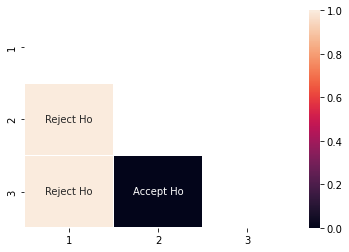

In [21]:
mat=posthoc_tukey_hsd(titanic['fare'],titanic['pclass'])
labels=mat.applymap(lambda x: 'Reject Ho' if x==1 else 'Accept Ho')
mask=np.triu(np.ones_like(mat))
sns.heatmap(mat,mask=mask, linewidth=0.5, annot=labels, fmt='')


Scipy-posthoc also provided other pairwise comparison tests, such as t-test that can be adjusted according to the numner of test done to correct family-error rate. the output of this the is a matrix of p-value of each comparison. As you can see, below, with this T-test, the result from comparing pclass 2 and pclass 3 is to accept Ho, consistent with Tukey HSD result.

In [25]:
posthoc_ttest([titanic['pclass']==i for i in titanic['pclass'].unique()])

,1,2,3
1,1.000000e+00,1.839337e-42,4.086661e-54
2,1.839337e-42,1.000000e+00,6.930598e-02
3,4.086661e-54,6.930598e-02,1.000000e+00


In [27]:
hasil=posthoc_ttest([titanic['pclass']==i for i in titanic['pclass'].unique()]).applymap(lambda x: 'Reject Ho' if x<=0.05 else 'Accept Ho')
hasil.reset_index().melt(id_vars=['index']).iloc[[3,6,7]].rename(columns={'index':'group 1', 'variable':'group 2', 'value':'result'}).reset_index(drop=True)

,group 1,group 2,result
0,1,2,Reject Ho
1,1,3,Reject Ho
2,2,3,Accept Ho


# Keys Takeaway
* *Post hoc* test is a follow up pairwise comparison test for ANOVA.
* When doing multiple comparison test, the rate of type one error increased, *post hoc* test correct this error.
* Python has scikit-poshocs library that offers post hoc tests which can be easily integrated with other libraries.

Reference:  
* https://statisticsbyjim.com/anova/post-hoc-tests-anova/  
* https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/post-hoc/  
* https://www.statology.org/tukey-test-python/  
* https://en.wikipedia.org/wiki/Tukey's_range_test  
* https://en.wikipedia.org/wiki/Family-wise_error_rate  
* https://scikit-posthocs.readthedocs.io/en/latest/intro/
* https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_ttest/  
* https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_tukey_hsd/